# Imports & Setup

In [15]:
import statistics 

from sklearn import model_selection
from sklearn.metrics import roc_auc_score
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from pprint import pprint

import fatf
import fatf.utils.array.validation as fuav
import fatf.transparency.predictions.counterfactuals as fatf_cf
import fatf.transparency.predictions.surrogate_explainers as fatf_surrogates
import fatf.vis.lime as fatf_vis_lime
import fatf.transparency.models.feature_influence as fatf_fi

import fatf.vis.feature_influence as fatf_vis_fi

import pickle
import warnings

from typing import Callable, Dict, List, Optional, Set, Tuple, Union

warnings.filterwarnings("ignore")


In [3]:
def load_dataset(dataset_name,
                 features,
                 scale=True,
                 test=True,
                 dummy=False):
    """Load the RFD dataset from the csv file into a dataframe.

    Args:
        dataset_name (str): dataset name
        features (lst): list of features
        scale (bool): if to use scaled data (with standard scalar)
        test (bool): which split to load, train or test

    Returns:
        X: features of all instances in a dataframe
        y: labels of all instances in a numpy array
    """
    dataset_df = pd.DataFrame()

    # load rfd dataset
    if dataset_name == "mimic":
        if scale:
            if test == True:
                if dummy:
                    dataset_file_path = (
                        "data/public/dummy_data.csv"
                    )
                else:
                    dataset_file_path = (
                        "data/private/combined_test_data_standardscale.csv"
                    )
            else:
                dataset_file_path = (
                    "data/private/combined_training_data_standardscale.csv"
                )
        else:
            if test == True:
                dataset_file_path = ("rfd_model/combined_test_data.csv")
            else:
                dataset_file_path = (
                    "rfd_model/combined_training_data.csv")
        dataset_df = pd.read_csv(dataset_file_path,
                                 # header=0,
                                 engine="python")

        # deal with airway and sex not being binary, even though they should?

    X = dataset_df[features]
    y = dataset_df['outcome']

    return X, y

def inverse_scaling(data, features):
    '''
    Get feature values back to their original unscaled values

    Args:
        data (dataframe): one row per set of readings
        features (list): the complete set of features, not to be modified

    Returns:
        Dataframe of the unscaled readings

    '''
    with open('data/private/standard_scaler.pkl', 'rb') as file:
        scaler = pickle.load(file)

    inversed = pd.DataFrame(scaler.inverse_transform(data), columns=features)

    return inversed

def sample_uncertainty(sample_cases):
    # for given case(s), calculate mean and sd of model predictions
    means = []
    stds = [] # standard deviations
    for i in range(num_samples):
        probs = []
        probs.append(rf_1.predict_proba(sample_case.to_numpy())[i, 1])
        probs.append(rf_2.predict_proba(sample_case.to_numpy())[i, 1])
        probs.append(rf_3.predict_proba(sample_case.to_numpy())[i, 1])
        probs.append(rf_4.predict_proba(sample_case.to_numpy())[i, 1])
        probs.append(rf_5.predict_proba(sample_case.to_numpy())[i, 1])
        means.append(statistics.mean(probs))
        stds.append(statistics.pstdev(probs))
    return means, stds

def textualise_counterfactuals(
        instance: Union[np.ndarray, np.void],
        counterfactuals: np.ndarray,
        instance_class: Optional[Union[int, str]] = None,
        counterfactuals_distances: Optional[np.ndarray] = None,
        counterfactuals_predictions: Optional[np.ndarray] = None,
        unscale: Optional[bool] = False,
        fractional_difference: Optional[float] = None) ->str:
    """
    Translates a counterfactuals array into a textual description.

    Parameters
    ----------
    instance : numpy.ndarray or numpy.void
        A 1-dimensional numpy array representing a data point for which
        counterfactuals were calculated.
    counterfactuals : numpy.ndarray
        A 2-dimensional numpy array with the counterfactual data points.
    instance_class : string or integer, optional (default=None)
        The class of the input ``instance``.
    counterfactuals_distances : numpy.ndarray, optional (default=None)
        A 1-dimensional numpy array with distances from the input ``instance``
        to every counterfactual data point.
    counterfactuals_predictions : numpy.ndarray, optional (default=None)
        A 1-dimensional numpy array with predictions for every counterfactual
        data point.

    Raises
    ------
    IncorrectShapeError
        ``instance`` is not a 1-dimensional numpy array or any of
        ``counterfactuals``, ``counterfactuals_distances`` or
        ``counterfactuals_predictions`` is not a 2-dimensional numpy array.
    IndexError
        The ``counterfactuals`` and the ``instance`` column indices disagree.
    TypeError
        The ``instance_class`` parameter is neither an integer nor a string.
        The types of the ``instance`` and the ``counterfactuals`` arrays are
        different.
    ValueError
        The ``instance`` is not of a base type (strings and/or numbers);
        the ``counterfactuals`` is not of a base type; the
        ``counterfactuals_distances`` is not a purely numerical array; or
        ``counterfactuals_predictions`` is not a base array. Either the length
        of the ``counterfactuals_distances`` array or of the
        ``counterfactuals_predictions`` array is not the same as the number of
        rows in the ``counterfactuals`` array. The type of the
        ``instance_class`` is different than the type of the
        ``counterfactuals_predictions`` array.

    Returns
    -------
    textualisation : string
        A string representation of the ``counterfactuals``.
    """
    # pylint: disable=too-many-branches,too-many-statements,too-many-locals

    if not fuav.is_1d_like(instance):
        raise IncorrectShapeError('The instance has to be a 1-dimensional '
                                  'numpy array.')
    instance_2d = np.array([instance])
    if not fuav.is_base_array(instance_2d):
        raise ValueError('The instance has to be of a base type (strings '
                         'and/or numbers).')
    #
    if not fuav.is_2d_array(counterfactuals):
        raise IncorrectShapeError('The counterfactuals array should be a '
                                  '2-dimensional numpy array.')
    if not fuav.is_base_array(counterfactuals):
        raise ValueError('The counterfactuals array has to be of a base type '
                         '(strings and/or numbers).')
    #
    if not fuav.are_similar_dtype_arrays(instance_2d, counterfactuals):
        raise TypeError('The type of the instance and the counterfactuals '
                        'arrays do not agree.')
    # These have to be valid indices for the instance
    if not fuav.is_structured_array(counterfactuals):
        if counterfactuals.shape[1] != instance.shape[0]:
            raise IndexError('The counterfactuals and instance column indices '
                             'do not agree. (The two arrays have different '
                             'number of columns.)')
    #
    if instance_class is not None:
        if not isinstance(instance_class, (int, str, np.int32, np.int64)):
            raise TypeError('The instance_class has to be either an integer '
                            'or a string.')
    #
    if counterfactuals_distances is not None:
        if not fuav.is_1d_array(counterfactuals_distances):
            raise IncorrectShapeError('The counterfactuals_distances array '
                                      'should be a 1-dimensional array.')
        if not fuav.is_numerical_array(counterfactuals_distances):
            raise ValueError('The counterfactuals_distances array should be '
                             'purely numerical.')
        if counterfactuals.shape[0] != counterfactuals_distances.shape[0]:
            raise ValueError('The counterfactuals_distances array should be '
                             'of the same length as the number of rows in the '
                             'counterfactuals array.')
    #
    if counterfactuals_predictions is not None:
        if not fuav.is_1d_array(counterfactuals_predictions):
            raise IncorrectShapeError('The counterfactuals_predictions array '
                                      'should be a 1-dimensional array.')
        if not fuav.is_base_array(counterfactuals_predictions):
            raise ValueError('The counterfactuals_predictions array should be '
                             'of a base type (numbers and/or strings).')
        if counterfactuals.shape[0] != counterfactuals_predictions.shape[0]:
            raise ValueError('The counterfactuals_predictions array should be '
                             'of the same length as the number of rows in the '
                             'counterfactuals array.')
        if instance_class is not None:
            if not fuav.are_similar_dtype_arrays(
                    np.array([instance_class]), counterfactuals_predictions):
                raise ValueError('The type of the instance_class is different '
                                 'than the type of the '
                                 'counterfactuals_predictions array.')

    # Sort the counterfactuals in case they are not sorted
    if counterfactuals_distances is not None:
        ordering = np.argsort(counterfactuals_distances)
        counterfactuals = counterfactuals[ordering]
        counterfactuals_distances = counterfactuals_distances[ordering]
        if counterfactuals_predictions is not None:
            counterfactuals_predictions = counterfactuals_predictions[ordering]

    
    # Get feature names
    if fuav.is_structured_array(counterfactuals):
        feature_names = counterfactuals.dtype.names
    else:
        feature_names = list(range(counterfactuals.shape[1]))

    if instance_class is None:
        instance_class_str = ''
    else:
        instance_class_str = ' of class *{}*'.format(class_names[instance_class])
    output = ['Instance{}:'.format(instance_class_str),
              '{}\n'.format(instance),
              #'Feature names: {}\n'.format(feature_names)
              ]  # yapf: disable
    
    cf_template = '    feature *{}*: *{}* -> *{}*'

    if unscale:
        instance = inverse_scaling(instance.reshape(1, -1), features).to_numpy()[0]


    for i in range(counterfactuals.shape[0]):

        # Inverse scaling if required

        if unscale:
            counterfactuals[i] = inverse_scaling(counterfactuals[i].reshape(1, -1), features).to_numpy()[0]

        if counterfactuals_predictions is None:
            cf_instance_class_str = ''
        else:
            cf_instance_class_str = ' of class *{}*'.format(
                class_names[counterfactuals_predictions[i]])

        output.append(
            'Counterfactual instance{}:'.format(cf_instance_class_str))

        if counterfactuals_distances is not None:
            output.append('Distance: {}'.format(counterfactuals_distances[i]))

        for feature_name in feature_names:
            i_val = instance[feature_name]
            c_val = counterfactuals[i][feature_name]
        
            if fractional_difference:
                if abs((i_val-c_val)/i_val) > fractional_difference:
                    output.append(cf_template.format(features[feature_name], i_val, c_val))
            else:
                if i_val != c_val:
                    output.append(cf_template.format(features[feature_name], i_val, c_val))
        output[-1] += '\n'

    # Remove the trailing new-line
    if output[-1][-1] == '\n':
        output[-1] = output[-1][:-1]

    textualisation = '\n'.join(output)
    return textualisation


In [4]:
scale = True
num_samples = 1
fatf.setup_random_seed(42)
seed = 42


24-Aug-05 13:02:19 fatf         INFO     Seeding RNGs using the input parameter.
24-Aug-05 13:02:19 fatf         INFO     Seeding RNGs with 42.


In [5]:
class_names = {0: 'NRFD', 1: 'RFD'}

In [6]:
features = ['airway', 'fio2', 'spo2_min',
            'hco3', 'resp_min', 'resp_max',
            'bp_min', 'hr_min', 'hr_max', 'pain',
            'gcs_min', 'temp_min', 'temp_max',
            'haemoglobin', 'k', 'na', 'creatinine', 'bun',
            'bmi', 'los', 'age', 'sex'
            ]

In [7]:
# import rfd testset data
X_train, y_train = load_dataset('mimic',
                                features,
                                scale=scale,
                                test=False
                                )
X_test, y_test = load_dataset('mimic',
                              features,
                              scale=scale
                              )

In [8]:
X_test_dummy, y_test_dummy = load_dataset('mimic',
                              features,
                              scale=scale,
                              dummy=True
                              )

In [9]:
X_test_dummy

,airway,fio2,spo2_min,hco3,resp_min,resp_max,bp_min,hr_min,hr_max,pain,...,temp_max,haemoglobin,k,na,creatinine,bun,bmi,los,age,sex
0,1.756151,0.575756,-0.026491,0.692595,-2.480842,0.321948,-0.544739,0.304917,0.523052,-0.604484,...,0.669076,-0.403741,-1.359243,-1.334461,-0.706398,-0.813236,0.020714,0.120239,-0.492656,1.088614
1,-0.569427,-0.088629,-0.879925,0.482812,-1.673118,-1.667486,-0.683734,-0.597086,-0.861744,-0.604484,...,-0.358890,-0.406778,0.096425,-0.294487,1.000850,1.496098,-0.023504,-0.506162,-0.268506,-0.918599
2,-0.569427,0.132833,0.257987,0.902378,1.073142,0.653521,1.169535,1.142492,0.811551,-0.180324,...,0.273803,-0.379450,1.734052,0.121503,4.349681,1.159320,0.039715,-0.264253,-0.328110,1.088614
3,-0.569427,0.132833,0.542465,0.063247,0.588508,-0.506983,0.891544,-1.499089,-1.842641,-0.604484,...,-1.782272,-0.412851,-1.177284,0.537493,-0.509408,-0.091569,-0.088882,-0.065257,0.375843,-0.918599
4,1.756151,-0.531552,1.111420,-0.775883,-1.026939,-0.838555,0.984208,-1.112516,-1.265643,-0.604484,...,0.431940,-0.367304,-0.995326,-0.294487,-0.312417,-0.139680,-0.006306,-0.108562,0.214262,-0.918599


In [10]:
# Load trained random forest model
if scale:
    model = pickle.load(open('models/private/rfd_model_combined_standardscale.pickle', 'rb'))
else:
    model = pickle.load(open('models/private/rf.pickle', 'rb'))

result = roc_auc_score(
    y_test, model.predict_proba(X_test.to_numpy())[:, 1])
print(f'Test set AUC performance {result:.3f}')
result_dummy = roc_auc_score(
    y_test_dummy, model.predict_proba(X_test_dummy.to_numpy())[:, 1])
print(f'Dummy test set AUC performance {result_dummy:.3f}')

Test set AUC performance 0.882
Dummy test set AUC performance 1.000


# Sample cases

For now everything below will be a sample case from the dummy file

In [11]:
sample_case = X_test_dummy.sample(n=num_samples, random_state=seed)
sample_case_outcome = y_test_dummy.sample(n=num_samples, random_state=seed)

In [80]:
# Generate RFD prediction for sample case(s)
# 0 = not ready for discharge, 1 = ready for discharge, 0.5 = decision threshold
model.predict_proba(sample_case.to_numpy())[:, 1]

array([0.49531122])

# Counterfactuals

In [81]:
cf_explainer = fatf_cf.CounterfactualExplainer(
    model=model,
    dataset=X_train.to_numpy(),
    categorical_indices=[],
    default_numerical_step_size=0.1)

In [74]:
# Get a Counterfactual Explanation tuple for this data point
dp_1_cf_tuple = cf_explainer.explain_instance(sample_case.to_numpy()[0])

# Only use the requested number of counterfactuals (with shortest distance)
num_cfs = 3
dp_1_cf_tuple = tuple(arr[:num_cfs] for arr in dp_1_cf_tuple)

dp_1_cfs, dp_1_cfs_distances, dp_1_cfs_predictions = dp_1_cf_tuple
dp_1_cfs_predictions_names = np.array(
    [class_names[i] for i in dp_1_cfs_predictions])



In [75]:
print('\nCounterfactuals for the data point:')
pprint(dp_1_cfs)
print('\nDistances between the counterfactuals and the data point:')
pprint(dp_1_cfs_distances)
print('\nClasses (indices and class names) of the counterfactuals:')
pprint(dp_1_cfs_predictions)
pprint(dp_1_cfs_predictions_names)


Counterfactuals for the data point:
array([[-0.56942718, -0.08862862, -0.87992482,  0.48281246, -1.67311802,
        -1.66748575, -0.68373439, -0.59708594, -0.86174412, -0.60448357,
         0.36586264, -0.23415682, -0.35889024, -0.40677781,  0.09642508,
        -0.29448665,  1.00084975,  1.49609809, -0.02350413, -0.54811423,
        -0.2685055 , -0.91859914],
       [-0.56942718, -0.08862862, -0.87992482,  0.48281246, -1.67311802,
        -1.66748575, -0.68373439, -0.59708594, -0.86174412, -0.60448357,
         0.36586264, -0.23415682, -0.35889024, -0.40677781,  0.09642508,
        -0.29448665,  1.00084975,  1.49609809, -0.02350413, -0.54811423,
        -0.2685055 , -0.91859914],
       [-0.56942718, -0.08862862, -0.87992482,  0.48281246, -1.67311802,
        -1.66748575, -0.68373439, -0.59708594, -0.86174412, -0.60448357,
         0.36586264, -0.23415682, -0.35889024, -0.40677781,  0.09642508,
        -0.29778299,  1.00084975,  1.49609809, -0.02350413, -0.54811423,
        -0.268505

In [85]:
sample_case

,airway,fio2,spo2_min,hco3,resp_min,resp_max,bp_min,hr_min,hr_max,pain,...,temp_max,haemoglobin,k,na,creatinine,bun,bmi,los,age,sex
1,-0.569427,-0.088629,-0.879925,0.482812,-1.673118,-1.667486,-0.683734,-0.597086,-0.861744,-0.604484,...,-0.35889,-0.406778,0.096425,-0.294487,1.00085,1.496098,-0.023504,-0.506162,-0.268506,-0.918599


In [84]:
# Textualise the counterfactuals
dp_1_cfs_text = textualise_counterfactuals(
    sample_case.to_numpy()[0],
    dp_1_cfs,
    instance_class=sample_case_outcome.to_numpy()[0],
    counterfactuals_distances=dp_1_cfs_distances,
    counterfactuals_predictions=dp_1_cfs_predictions,
    unscale = True,
    fractional_difference=0.001) # i.e. must be at least 0.1% different
print(dp_1_cfs_text)

Instance of class *RFD*:
[-0.56942718 -0.08862862 -0.87992482  0.48281246 -1.67311802 -1.66748575
 -0.68373439 -0.59708594 -0.86174412 -0.60448357  0.36586264 -0.23415682
 -0.35889024 -0.40677781  0.09642508 -0.29448665  1.00084975  1.49609809
 -0.02350413 -0.50616173 -0.2685055  -0.91859914]

Counterfactual instance of class *RFD*:
Distance: 0.041952503789225215
    feature *los*: *38.085600000000014* -> *32.179348527323995*

Counterfactual instance of class *RFD*:
Distance: 0.04195250378922566
    feature *airway*: *2.498001805406602e-16* -> *5.551115123125783e-17*
    feature *los*: *38.085600000000014* -> *32.179348527323995*

Counterfactual instance of class *RFD*:
Distance: 0.04524884087737885
    feature *los*: *38.085600000000014* -> *32.179348527323995*


# Surrogate tree explainer

In [86]:
# Create a LIME explainer
tree = fatf_surrogates.TabularBlimeyTree(
    X_train.to_numpy(),
    model,
    feature_names=features,
    class_names=list(class_names.values()))

--- Instance 0 ---
{'NRFD': {'age': 0.0,
          'airway': 0.056617833460483616,
          'bmi': 0.0,
          'bp_min': 0.0,
          'bun': 0.0,
          'creatinine': 0.0,
          'fio2': 0.0,
          'gcs_min': 0.7651410099124144,
          'haemoglobin': 0.0,
          'hco3': 0.0,
          'hr_max': 0.0,
          'hr_min': 0.009528978812385458,
          'k': 0.0,
          'los': 0.1687121778147164,
          'na': 0.0,
          'pain': 0.0,
          'resp_max': 0.0,
          'resp_min': 0.0,
          'sex': 0.0,
          'spo2_min': 0.0,
          'temp_max': 0.0,
          'temp_min': 0.0},
 'RFD': {'age': 0.0,
         'airway': 0.05661783346047686,
         'bmi': 0.0,
         'bp_min': 0.0,
         'bun': 0.0,
         'creatinine': 0.0,
         'fio2': 0.0,
         'gcs_min': 0.7651410099124197,
         'haemoglobin': 0.0,
         'hco3': 0.0,
         'hr_max': 0.0,
         'hr_min': 0.009528978812385461,
         'k': 0.0,
         'los': 0.168712

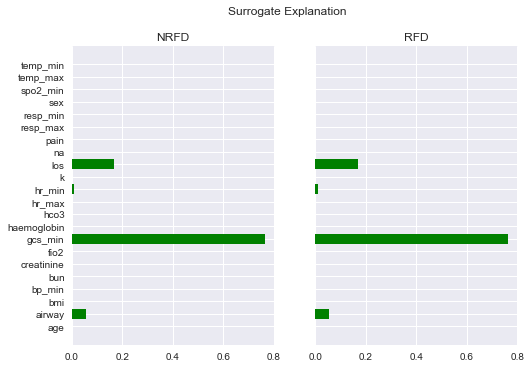

In [87]:
# Explain an instance
for instance in range(num_samples):
    print(f'--- Instance {instance} ---')
    tree_explanation = tree.explain_instance(
        sample_case.to_numpy()[instance], samples_number=500)

    # Display the textual explanation
    pprint(tree_explanation)

    # Plot the explanation
    fatf_vis_lime.plot_lime(tree_explanation)


# LIME

In [88]:
# Create a LIME explainer
lime = fatf_surrogates.TabularBlimeyLime(
    X_train.to_numpy(),
    model,
    feature_names=features,
    class_names=list(class_names.values()))

In [89]:
sample_case.to_numpy()[0]

array([-0.56942718, -0.08862862, -0.87992482,  0.48281246, -1.67311802,
       -1.66748575, -0.68373439, -0.59708594, -0.86174412, -0.60448357,
        0.36586264, -0.23415682, -0.35889024, -0.40677781,  0.09642508,
       -0.29448665,  1.00084975,  1.49609809, -0.02350413, -0.50616173,
       -0.2685055 , -0.91859914])

In [90]:
# Explain an instance
lime_explanation = lime.explain_instance(
    X_train.to_numpy()[index_to_explain, :], samples_number=500)

# Display the textual explanation
pprint(lime_explanation)

# Plot the explanation
fatf_vis_lime.plot_lime(lime_explanation)

NameError: name 'index_to_explain' is not defined

Below shows implementation with FAT Forensics example dataset

In [91]:
import fatf.utils.data.datasets as fatf_datasets
import fatf.utils.models as fatf_models

24-Aug-05 12:24:34 fatf.transparency.predictions.surrogate_explainers INFO     Selecting 4 features with forward selection.


{'setosa': {'*petal length (cm)* <= 1.60': 0.9120349861232682,
            '*petal width (cm)* <= 0.30': 0.05036417351241962,
            '3.30 < *sepal width (cm)*': 0.039179052050646763,
            '5.10 < *sepal length (cm)* <= 5.80': -0.020507812104786225},
 'versicolor': {'*petal length (cm)* <= 1.60': -0.59817558993236,
                '*petal width (cm)* <= 0.30': 0.1113229710225831,
                '3.30 < *sepal width (cm)*': 0.039205807892404035,
                '5.10 < *sepal length (cm)* <= 5.80': 0.0034886323161647317},
 'virginica': {'*petal length (cm)* <= 1.60': -0.31385939619090925,
               '*petal width (cm)* <= 0.30': -0.16168714453500213,
               '3.30 < *sepal width (cm)*': -0.07838485994305053,
               '5.10 < *sepal length (cm)* <= 5.80': 0.017019179788621528}}


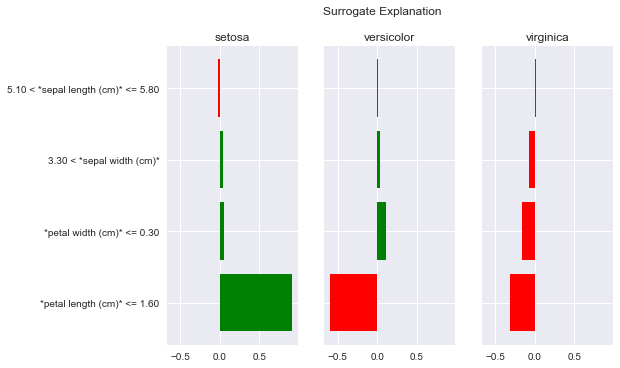

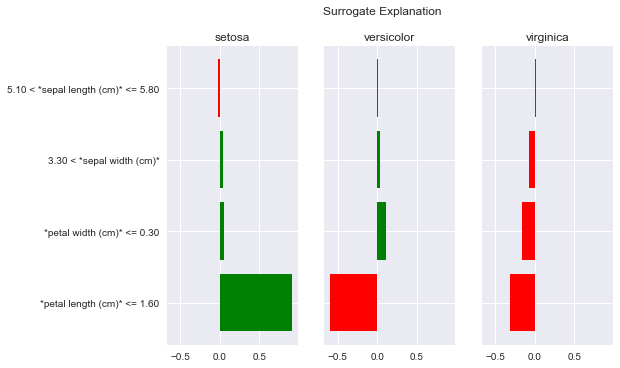

In [92]:
# Load data
iris_data_dict = fatf_datasets.load_iris()
iris_X = iris_data_dict['data']
iris_y = iris_data_dict['target']
iris_feature_names = iris_data_dict['feature_names'].tolist()
iris_class_names = iris_data_dict['target_names'].tolist()

# Train a model
clf = fatf_models.KNN()
clf.fit(iris_X, iris_y)

# Create a LIME explainer
lime = fatf_surrogates.TabularBlimeyLime(
    iris_X,
    clf,
    feature_names=iris_feature_names,
    class_names=iris_class_names)

# Choose an index of the instance to be explained
index_to_explain = 10

# Explain an instance
lime_explanation = lime.explain_instance(
    iris_X[index_to_explain, :], samples_number=500)

# Display the textual explanation
pprint(lime_explanation)

# Plot the explanation
fatf_vis_lime.plot_lime(lime_explanation)

In [ ]:
iris_X[index_to_explain, :]

array([5.4, 3.7, 1.5, 0.2], dtype=float32)

# Partial Dependence

In [96]:
import fatf.utils.data.datasets as fatf_datasets
import fatf.utils.models as fatf_models




In [12]:
# Select a feature to be explained
selected_feature_index = 10
selected_feature_name = features[selected_feature_index]
print('Explaining feature (index: {}): {}.'.format(selected_feature_index,
                                                   selected_feature_name))





Explaining feature (index: 10): gcs_min.


In [16]:
# Define the number of samples to be generated (granularity of the explanation)
linspace_samples = 25

# Calculate Partial Dependence
pd_array, pd_linspace = fatf_fi.partial_dependence(
    X_train.to_numpy(), model, selected_feature_index, steps_number=linspace_samples)



Explaining class RFD.


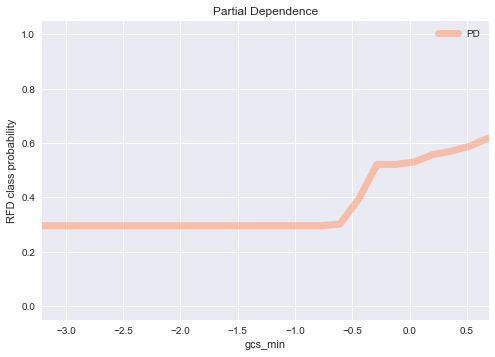

In [17]:
# Select class for which the explanation will be produced
explanation_class = 1
explanation_class_name = class_names[explanation_class]
print('Explaining class {}.'.format(explanation_class_name))

# Plot Partial Dependence on its own
pd_plot_clean = fatf_vis_fi.plot_partial_dependence(
    pd_array,
    pd_linspace,
    explanation_class,
    class_name=explanation_class_name,
    feature_name=selected_feature_name)

# Tree interpreter

In [340]:
from treeinterpreter import treeinterpreter as ti
# fit a scikit-learn's regressor model

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

prediction, bias, contributions = ti.predict(rf, X_test)

class_to_predict = 1

In [341]:
prediction = prediction[:, class_to_predict]
bias = bias[:, class_to_predict]

In [342]:
result = roc_auc_score(
    y_test, rf.predict_proba(X_test.to_numpy())[:, 1])
print(f'Test set AUC performance {result:.3f}')

Test set AUC performance 0.900


In [343]:
len(np.sum(contributions, axis=1))

2806

In [344]:
assert(np.allclose(prediction, bias + np.sum(contributions, axis=1)))
assert(np.allclose(rf.predict(X_test), bias + np.sum(contributions, axis=1)))

ValueError: operands could not be broadcast together with shapes (2806,) (2806,2) 

In [345]:
from treeinterpreter import treeinterpreter as ti
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import numpy as np
 
from sklearn.datasets import load_boston
boston = load_boston()
rf = RandomForestRegressor()
rf.fit(boston.data[:300], boston.target[:300])

RandomForestRegressor()

In [346]:
instances = boston.data[[300, 309]]

instances[0]
print ("Instance 0 prediction:", rf.predict(instances[0].reshape(1, -1)))
print ("Instance 1 prediction:", rf.predict(instances[1].reshape(1, -1)))

Instance 0 prediction: [29.974]
Instance 1 prediction: [22.864]


In [349]:
instances[0]

array([4.4170e-02, 7.0000e+01, 2.2400e+00, 0.0000e+00, 4.0000e-01,
       6.8710e+00, 4.7400e+01, 7.8278e+00, 5.0000e+00, 3.5800e+02,
       1.4800e+01, 3.9086e+02, 6.0700e+00])

In [350]:
prediction, bias, contributions = ti.predict(rf, instances)

In [351]:
prediction

array([[29.974],
       [22.864]])

In [352]:
bias

array([25.44531333, 25.44531333])

In [353]:
contributions

array([[-1.16448233e-01,  7.21740589e-02,  2.10581422e-01,
        -9.05311355e-03, -1.69932306e-02,  3.63647029e+00,
        -8.90085247e-03, -3.18879440e-01,  1.26702226e-01,
        -4.02599668e-01,  3.49186220e-01, -2.13382481e-01,
         1.21982947e+00],
       [ 4.54166770e-01,  7.51079494e-03,  1.67661895e-02,
        -2.38713148e-02,  8.76773776e-02, -5.29794249e+00,
        -2.29537566e-01,  3.73059692e-02,  1.55643719e-03,
        -9.38570670e-02,  1.01796034e-01, -8.95050779e-02,
         2.44662061e+00]])

# Presenting tailored explainations

In [95]:
explainers = ['cfe', #counterfactual explanations
              'shap',
              'lime']

user_types = ['domain expert',
        'user',
        'public']

user = 'domain_expert'

In [94]:
if user == 'domain expert':
    print('Working')

# Uncertainty - potential work in progress

In [71]:
rf_1 = RandomForestClassifier(random_state=7)
rf_1.fit(X_train, y_train)
rf_2 = RandomForestClassifier(random_state=39)
rf_2.fit(X_train, y_train)
rf_3 = RandomForestClassifier(random_state=42)
rf_3.fit(X_train, y_train)
rf_4 = RandomForestClassifier(random_state=97)
rf_4.fit(X_train, y_train)
rf_5 = RandomForestClassifier(random_state=113)
rf_5.fit(X_train, y_train)

RandomForestClassifier(random_state=113)

In [52]:
sample_uncertainty(sample_case)

([0.5760000000000001, 0.428], [0.05276362383309167, 0.04166533331199932])

In [49]:
#Print output
for case in range(num_samples):
    print(f'For patient {case} the model predicts {class_names[model.predict(sample_case)[case]]} with probability {model.predict_proba(sample_case.to_numpy())[case, 1]:.2f}, mean {sample_uncertainty[0][case]:.2f} +/- {sample_uncertainty[1][case]:.2f}')

TypeError: 'function' object is not subscriptable